# Comprehensive Wilson-Cowan Model Variants: Simulation & Comparison

This notebook provides a comprehensive overview and comparison of all 11 Wilson-Cowan model variants available in the BrainMass library.

## Variant Reference Table

| Variant | Key Feature | States | Use Case |
|---------|-------------|--------|----------|
| **WilsonCowanStep** | Saturation terms | 2 (E,I) | General purpose modeling |
| **WilsonCowanNoSaturationStep** | No saturation | 2 (E,I) | Simplified dynamics |
| **WilsonCowanSymmetricStep** | Unified E/I params | 2 (E,I) | Parameter reduction |
| **WilsonCowanSimplifiedStep** | 2 weights only | 2 (E,I) | Pedagogical demonstrations |
| **WilsonCowanLinearStep** | ReLU activation | 2 (E,I) | Optimization/learning tasks |
| **WilsonCowanDivisiveStep** | Gain modulation | 2 (E,I) | Visual cortex normalization |
| **WilsonCowanDivisiveInputStep** | Input division | 2 (E,I) | Contrast normalization |
| **WilsonCowanDelayedStep** | Connection delays | 2 (E,I) | Network with transmission delays |
| **WilsonCowanAdaptiveStep** | Adaptation currents | 4 (E,I,aE,aI) | Fatigue/habituation modeling |
| **WilsonCowanThreePopulationStep** | Modulatory neurons | 3 (E,I,M) | Attention/arousal/neuromodulation |

## Part 1: Setup and Imports

In [2]:
import sys

sys.path.append(r'D:\codes\projects\brainmass')
sys.path.append(r'D:\codes\projects\brainstate')

import brainmass
import brainstate
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Set integration time step
brainstate.environ.set(dt=0.1 * u.ms)

# Plotting configuration
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Color scheme
E_COLOR = '#3498db'  # Blue for Excitation
I_COLOR = '#e74c3c'  # Red for Inhibition
M_COLOR = '#2ecc71'  # Green for Modulator
A_COLOR = '#f39c12'  # Orange for Adaptation

print("✅ All imports successful!")
print(f"   BrainState dt: {brainstate.environ.get_dt()}")

✅ All imports successful!
   BrainState dt: 0.1 * msecond


## Part 2: Individual Variant Demonstrations

We'll demonstrate each of the 11 Wilson-Cowan variants individually, showing their unique characteristics.

### 2.1: WilsonCowanStep (Standard)

The standard Wilson-Cowan model with saturation terms.

**Mathematical Formulation**:

$$\tau_E \frac{dr_E}{dt} = -r_E(t) + [1 - r \, r_E(t)] F_E(w_{EE} r_E(t) - w_{EI} r_I(t) + I_E(t))$$

$$\tau_I \frac{dr_I}{dt} = -r_I(t) + [1 - r \, r_I(t)] F_I(w_{IE} r_E(t) - w_{II} r_I(t) + I_I(t))$$

where $F_j(x) = \frac{1}{1 + e^{-a_j (x - \theta_j)}} - \frac{1}{1 + e^{a_j \theta_j}}$

**Key Features**:
- Saturation term $(1 - r \cdot r_E)$ limits maximum activity
- Sigmoid transfer function with adjustable gain and threshold
- 11 parameters total
- Most versatile variant for general modeling

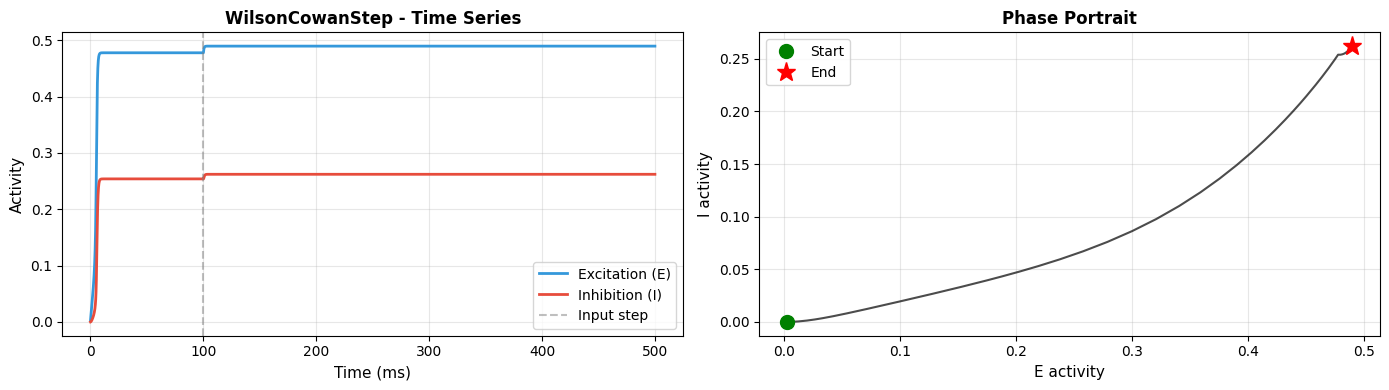

Observations:
  - Peak E activity: 0.489
  - Steady-state E: 0.489
  - Response shows typical transient dynamics with saturation


In [3]:
# Create model
model_standard = brainmass.WilsonCowanStep(
    1,  # Single node
    tau_E=1.0 * u.ms,
    tau_I=1.0 * u.ms,
    a_E=1.2,
    theta_E=2.8,
    a_I=1.0,
    theta_I=4.0,
    wEE=12.,
    wEI=13.,
    wIE=4.,
    wII=11.,
    r=1.
)
model_standard.init_all_states()

# Define simulation
duration = 500 * u.ms
n_steps = int(duration / brainstate.environ.get_dt())
indices = np.arange(n_steps)


# Input: Step function at t=100ms
def step_run(i):
    t = i * brainstate.environ.get_dt()
    inp = u.math.where(t > 100 * u.ms, 2.0, 0.5)  # JAX-compatible conditional
    model_standard.update(rE_inp=inp, rI_inp=0.0)
    return model_standard.rE.value, model_standard.rI.value


# Run simulation
rE_std, rI_std = brainstate.transform.for_loop(step_run, indices)
time = indices * brainstate.environ.get_dt()

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Time series
ax1.plot(time, rE_std[:, 0], color=E_COLOR, linewidth=2, label='Excitation (E)')
ax1.plot(time, rI_std[:, 0], color=I_COLOR, linewidth=2, label='Inhibition (I)')
ax1.axvline(100, color='gray', linestyle='--', alpha=0.5, label='Input step')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Activity', fontsize=11)
ax1.set_title('WilsonCowanStep - Time Series', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Phase portrait
ax2.plot(rE_std[:, 0], rI_std[:, 0], 'k-', linewidth=1.5, alpha=0.7)
ax2.plot(rE_std[0, 0], rI_std[0, 0], 'go', markersize=10, label='Start', zorder=5)
ax2.plot(rE_std[-1, 0], rI_std[-1, 0], 'r*', markersize=14, label='End', zorder=5)
ax2.set_xlabel('E activity', fontsize=11)
ax2.set_ylabel('I activity', fontsize=11)
ax2.set_title('Phase Portrait', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  - Peak E activity: {rE_std[:, 0].max():.3f}")
print(f"  - Steady-state E: {rE_std[-100:, 0].mean():.3f}")
print(f"  - Response shows typical transient dynamics with saturation")

### 2.2: WilsonCowanNoSaturationStep

Wilson-Cowan model without saturation terms - simpler dynamics.

**Mathematical Formulation**:

$$\tau_E \frac{dr_E}{dt} = -r_E(t) + F_E(w_{EE} r_E(t) - w_{EI} r_I(t) + I_E(t))$$

$$\tau_I \frac{dr_I}{dt} = -r_I(t) + F_I(w_{IE} r_E(t) - w_{II} r_I(t) + I_I(t))$$

**Key Features**:
- No saturation term - activities can grow larger
- Simpler mathematical form
- 10 parameters (one less than standard)
- Faster computation, but less biologically realistic

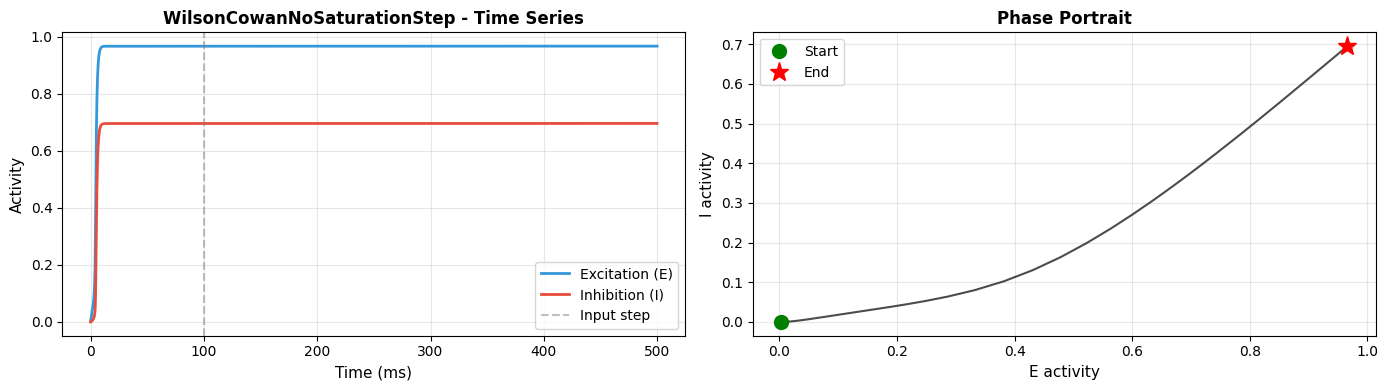

Observations:
  - Peak E activity: 0.966
  - Steady-state E: 0.966
  - Without saturation, activities can reach higher values


In [4]:
# Create model
model_nosat = brainmass.WilsonCowanNoSaturationStep(
    1,  # Single node
    tau_E=1.0 * u.ms,
    tau_I=1.0 * u.ms,
    a_E=1.2,
    theta_E=2.8,
    a_I=1.0,
    theta_I=4.0,
    wEE=12.,
    wEI=13.,
    wIE=4.,
    wII=11.
)
model_nosat.init_all_states()


# Run simulation
def step_run_nosat(i):
    t = i * brainstate.environ.get_dt()
    inp = u.math.where(t > 100 * u.ms, 2.0, 0.5)
    model_nosat.update(rE_inp=inp, rI_inp=0.0)
    return model_nosat.rE.value, model_nosat.rI.value


rE_nosat, rI_nosat = brainstate.transform.for_loop(step_run_nosat, indices)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Time series
ax1.plot(time, rE_nosat[:, 0], color=E_COLOR, linewidth=2, label='Excitation (E)')
ax1.plot(time, rI_nosat[:, 0], color=I_COLOR, linewidth=2, label='Inhibition (I)')
ax1.axvline(100, color='gray', linestyle='--', alpha=0.5, label='Input step')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Activity', fontsize=11)
ax1.set_title('WilsonCowanNoSaturationStep - Time Series', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Phase portrait
ax2.plot(rE_nosat[:, 0], rI_nosat[:, 0], 'k-', linewidth=1.5, alpha=0.7)
ax2.plot(rE_nosat[0, 0], rI_nosat[0, 0], 'go', markersize=10, label='Start', zorder=5)
ax2.plot(rE_nosat[-1, 0], rI_nosat[-1, 0], 'r*', markersize=14, label='End', zorder=5)
ax2.set_xlabel('E activity', fontsize=11)
ax2.set_ylabel('I activity', fontsize=11)
ax2.set_title('Phase Portrait', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  - Peak E activity: {rE_nosat[:, 0].max():.3f}")
print(f"  - Steady-state E: {rE_nosat[-100:, 0].mean():.3f}")
print(f"  - Without saturation, activities can reach higher values")

### 2.3: WilsonCowanSymmetricStep

Symmetric variant with unified E/I parameters - reduces parameter space.

**Mathematical Formulation**:

$$\tau \frac{dr_E}{dt} = -r_E(t) + [1 - r \, r_E(t)] F(w_{EE} r_E(t) - w_{EI} r_I(t) + I_E(t))$$

$$\tau \frac{dr_I}{dt} = -r_I(t) + [1 - r \, r_I(t)] F(w_{IE} r_E(t) - w_{II} r_I(t) + I_I(t))$$

where both E and I use the same $\tau$, $a$, and $\theta$ parameters.

**Key Features**:
- Unified time constant and transfer function parameters
- 8 parameters (vs 11 for standard)
- Simplifies parameter fitting
- Good for pedagogical demonstrations

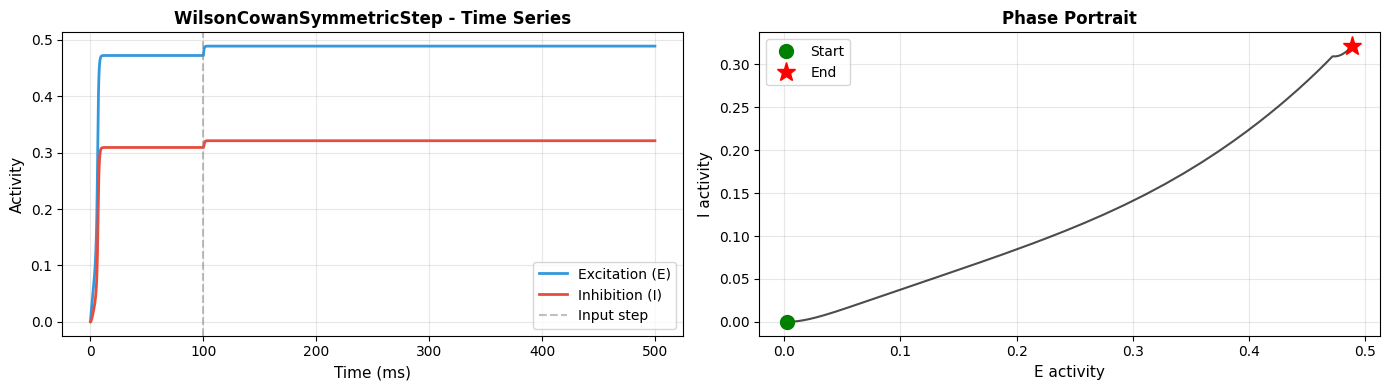

Observations:
  - Peak E activity: 0.489
  - Steady-state E: 0.489
  - Unified parameters simplify the model while maintaining core dynamics


In [5]:
# Create model with unified parameters
model_sym = brainmass.WilsonCowanSymmetricStep(
    1,  # Single node
    tau=1.0 * u.ms,  # Unified time constant
    a=1.2,  # Unified gain
    theta=2.8,  # Unified threshold
    wEE=12.,
    wEI=13.,
    wIE=4.,
    wII=11.,
    r=1.
)
model_sym.init_all_states()


# Run simulation
def step_run_sym(i):
    t = i * brainstate.environ.get_dt()
    inp = u.math.where(t > 100 * u.ms, 2.0, 0.5)
    model_sym.update(rE_inp=inp, rI_inp=0.0)
    return model_sym.rE.value, model_sym.rI.value


rE_sym, rI_sym = brainstate.transform.for_loop(step_run_sym, indices)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Time series
ax1.plot(time, rE_sym[:, 0], color=E_COLOR, linewidth=2, label='Excitation (E)')
ax1.plot(time, rI_sym[:, 0], color=I_COLOR, linewidth=2, label='Inhibition (I)')
ax1.axvline(100, color='gray', linestyle='--', alpha=0.5, label='Input step')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Activity', fontsize=11)
ax1.set_title('WilsonCowanSymmetricStep - Time Series', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Phase portrait
ax2.plot(rE_sym[:, 0], rI_sym[:, 0], 'k-', linewidth=1.5, alpha=0.7)
ax2.plot(rE_sym[0, 0], rI_sym[0, 0], 'go', markersize=10, label='Start', zorder=5)
ax2.plot(rE_sym[-1, 0], rI_sym[-1, 0], 'r*', markersize=14, label='End', zorder=5)
ax2.set_xlabel('E activity', fontsize=11)
ax2.set_ylabel('I activity', fontsize=11)
ax2.set_title('Phase Portrait', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  - Peak E activity: {rE_sym[:, 0].max():.3f}")
print(f"  - Steady-state E: {rE_sym[-100:, 0].mean():.3f}")
print(f"  - Unified parameters simplify the model while maintaining core dynamics")

### 2.4: WilsonCowanDivisiveStep (Gain Modulation)

**NEW VARIANT** - Divisive normalization through gain modulation.

**Mathematical Formulation**:

$$\tau_E \frac{dr_E}{dt} = -r_E(t) + \frac{1 - r \, r_E(t)}{\sigma_E + w_{EI} r_I(t)} F_E(w_{EE} r_E(t) - w_{EI} r_I(t) + I_E(t))$$

$$\tau_I \frac{dr_I}{dt} = -r_I(t) + \frac{1 - r \, r_I(t)}{\sigma_I + w_{IE} r_E(t)} F_I(w_{IE} r_E(t) - w_{II} r_I(t) + I_I(t))$$

**Key Features**:
- Divisive normalization through gain modulation
- Inhibition divides the gain of the transfer function
- Models contrast normalization in visual cortex
- Parameters: $\sigma_E$, $\sigma_I$ control normalization strength

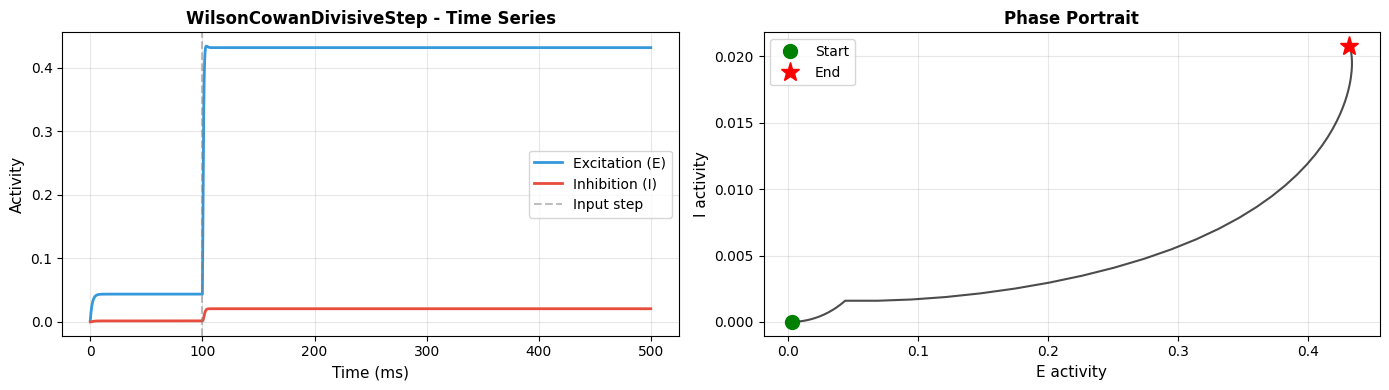

Observations:
  - Peak E activity: 0.434
  - Steady-state E: 0.432
  - Divisive normalization suppresses responses when inhibition is high
  - Models contrast normalization effects seen in visual cortex


In [6]:
# Create divisive gain modulation model
model_div = brainmass.WilsonCowanDivisiveStep(
    1,  # Single node
    tau_E=1.0 * u.ms,
    tau_I=1.0 * u.ms,
    a_E=1.2,
    theta_E=2.8,
    a_I=1.0,
    theta_I=4.0,
    wEE=6.,  # Reduced weights for stability
    wEI=6.5,
    wIE=2.,
    wII=5.5,
    sigma_E=1.,  # Normalization strength
    sigma_I=1.,
    r=1.
)
model_div.init_all_states()


# Run simulation
def step_run_div(i):
    t = i * brainstate.environ.get_dt()
    inp = u.math.where(t > 100 * u.ms, 2.0, 0.5)
    model_div.update(rE_inp=inp, rI_inp=0.0)
    return model_div.rE.value, model_div.rI.value


rE_div, rI_div = brainstate.transform.for_loop(step_run_div, indices)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Time series
ax1.plot(time, rE_div[:, 0], color=E_COLOR, linewidth=2, label='Excitation (E)')
ax1.plot(time, rI_div[:, 0], color=I_COLOR, linewidth=2, label='Inhibition (I)')
ax1.axvline(100, color='gray', linestyle='--', alpha=0.5, label='Input step')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Activity', fontsize=11)
ax1.set_title('WilsonCowanDivisiveStep - Time Series', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Phase portrait
ax2.plot(rE_div[:, 0], rI_div[:, 0], 'k-', linewidth=1.5, alpha=0.7)
ax2.plot(rE_div[0, 0], rI_div[0, 0], 'go', markersize=10, label='Start', zorder=5)
ax2.plot(rE_div[-1, 0], rI_div[-1, 0], 'r*', markersize=14, label='End', zorder=5)
ax2.set_xlabel('E activity', fontsize=11)
ax2.set_ylabel('I activity', fontsize=11)
ax2.set_title('Phase Portrait', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  - Peak E activity: {rE_div[:, 0].max():.3f}")
print(f"  - Steady-state E: {rE_div[-100:, 0].mean():.3f}")
print(f"  - Divisive normalization suppresses responses when inhibition is high")
print(f"  - Models contrast normalization effects seen in visual cortex")

### 2.5: WilsonCowanAdaptiveStep (Spike-Frequency Adaptation)

**NEW VARIANT** - 4-state system with adaptation currents.

**Mathematical Formulation**:

$$\tau_E \frac{dr_E}{dt} = -r_E(t) + [1 - r \, r_E(t)] F_E(w_{EE} r_E(t) - w_{EI} r_I(t) - a_E(t) + I_E(t))$$

$$\tau_I \frac{dr_I}{dt} = -r_I(t) + [1 - r \, r_I(t)] F_I(w_{IE} r_E(t) - w_{II} r_I(t) - a_I(t) + I_I(t))$$

$$\tau_{aE} \frac{da_E}{dt} = -a_E(t) + b_E r_E(t)$$

$$\tau_{aI} \frac{da_I}{dt} = -a_I(t) + b_I r_I(t)$$

**Key Features**:
- 4 dynamical states: $r_E$, $r_I$, $a_E$, $a_I$
- Adaptation currents build up with activity and suppress responses
- Models neural fatigue and habituation
- Slow time constants ($\tau_a$) capture long-term adaptation

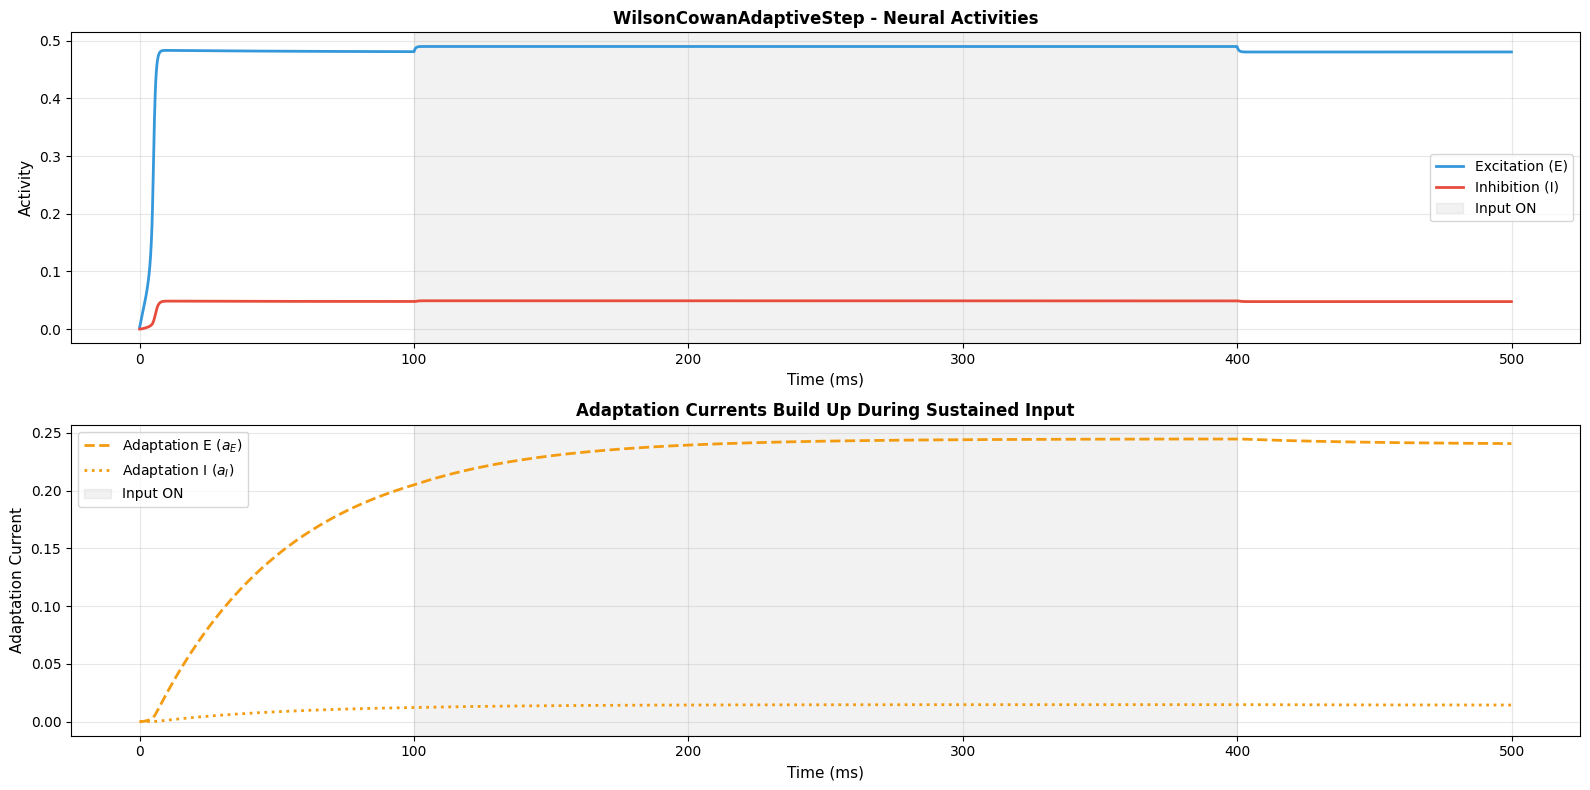

Observations:
  - Peak E activity: 0.490 (at t=104.8 * msecond)
  - Max adaptation: 0.245
  - Adaptation builds up during sustained input, reducing responses
  - After input turns off, adaptation slowly decays
  - Models neural fatigue and habituation phenomena


In [7]:
# Create adaptive model
model_adapt = brainmass.WilsonCowanAdaptiveStep(
    1,  # Single node
    tau_E=1.0 * u.ms,
    tau_I=1.0 * u.ms,
    tau_aE=50.0 * u.ms,  # Slow adaptation for E
    tau_aI=50.0 * u.ms,  # Slow adaptation for I
    b_E=0.5,  # Adaptation strength E
    b_I=0.3,  # Adaptation strength I
    a_E=1.2,
    theta_E=2.8,
    a_I=1.0,
    theta_I=4.0,
    wEE=12.,
    wEI=13.,
    wIE=4.,
    wII=11.,
    r=1.
)
model_adapt.init_all_states()


# Run simulation with longer input period to see adaptation
def step_run_adapt(i):
    t = i * brainstate.environ.get_dt()
    # Sustained input from 100-400ms
    inp = u.math.where((t > 100 * u.ms) & (t < 400 * u.ms), 2.0, 0.5)
    model_adapt.update(rE_inp=inp, rI_inp=0.0)
    return model_adapt.rE.value, model_adapt.rI.value, model_adapt.aE.value, model_adapt.aI.value


rE_adapt, rI_adapt, aE_adapt, aI_adapt = brainstate.transform.for_loop(step_run_adapt, indices)

# Visualize all 4 states
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 2, figure=fig)

# Time series of activities
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(time, rE_adapt[:, 0], color=E_COLOR, linewidth=2, label='Excitation (E)')
ax1.plot(time, rI_adapt[:, 0], color=I_COLOR, linewidth=2, label='Inhibition (I)')
ax1.axvspan(100, 400, color='gray', alpha=0.1, label='Input ON')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Activity', fontsize=11)
ax1.set_title('WilsonCowanAdaptiveStep - Neural Activities', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Time series of adaptation currents
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(time, aE_adapt[:, 0], color=A_COLOR, linewidth=2, label='Adaptation E ($a_E$)', linestyle='--')
ax2.plot(time, aI_adapt[:, 0], color=A_COLOR, linewidth=2, label='Adaptation I ($a_I$)', linestyle=':')
ax2.axvspan(100, 400, color='gray', alpha=0.1, label='Input ON')
ax2.set_xlabel('Time (ms)', fontsize=11)
ax2.set_ylabel('Adaptation Current', fontsize=11)
ax2.set_title('Adaptation Currents Build Up During Sustained Input', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  - Peak E activity: {rE_adapt[:, 0].max():.3f} (at t={time[np.argmax(rE_adapt[:, 0])]:.1f})")
print(f"  - Max adaptation: {aE_adapt[:, 0].max():.3f}")
print(f"  - Adaptation builds up during sustained input, reducing responses")
print(f"  - After input turns off, adaptation slowly decays")
print(f"  - Models neural fatigue and habituation phenomena")

### 2.6: WilsonCowanThreePopulationStep (E-I-M Model)

**NEW VARIANT** - Three-population model with modulatory neurons.

**Mathematical Formulation**:

$$\tau_E \frac{dr_E}{dt} = -r_E(t) + [1 - r \, r_E(t)] F_E(w_{EE} r_E(t) - w_{EI} r_I(t) + w_{EM} r_M(t) + I_E(t))$$

$$\tau_I \frac{dr_I}{dt} = -r_I(t) + [1 - r \, r_I(t)] F_I(w_{IE} r_E(t) - w_{II} r_I(t) + w_{IM} r_M(t) + I_I(t))$$

$$\tau_M \frac{dr_M}{dt} = -r_M(t) + [1 - r \, r_M(t)] F_M(w_{ME} r_E(t) - w_{MI} r_I(t) + w_{MM} r_M(t) + I_M(t))$$

**Key Features**:
- 3 interacting populations: Excitatory, Inhibitory, Modulatory
- Modulator enhances both E and I populations ($w_{EM}$, $w_{IM}$)
- Models attention, arousal, and neuromodulation
- Can simulate cholinergic, dopaminergic, or other modulatory effects

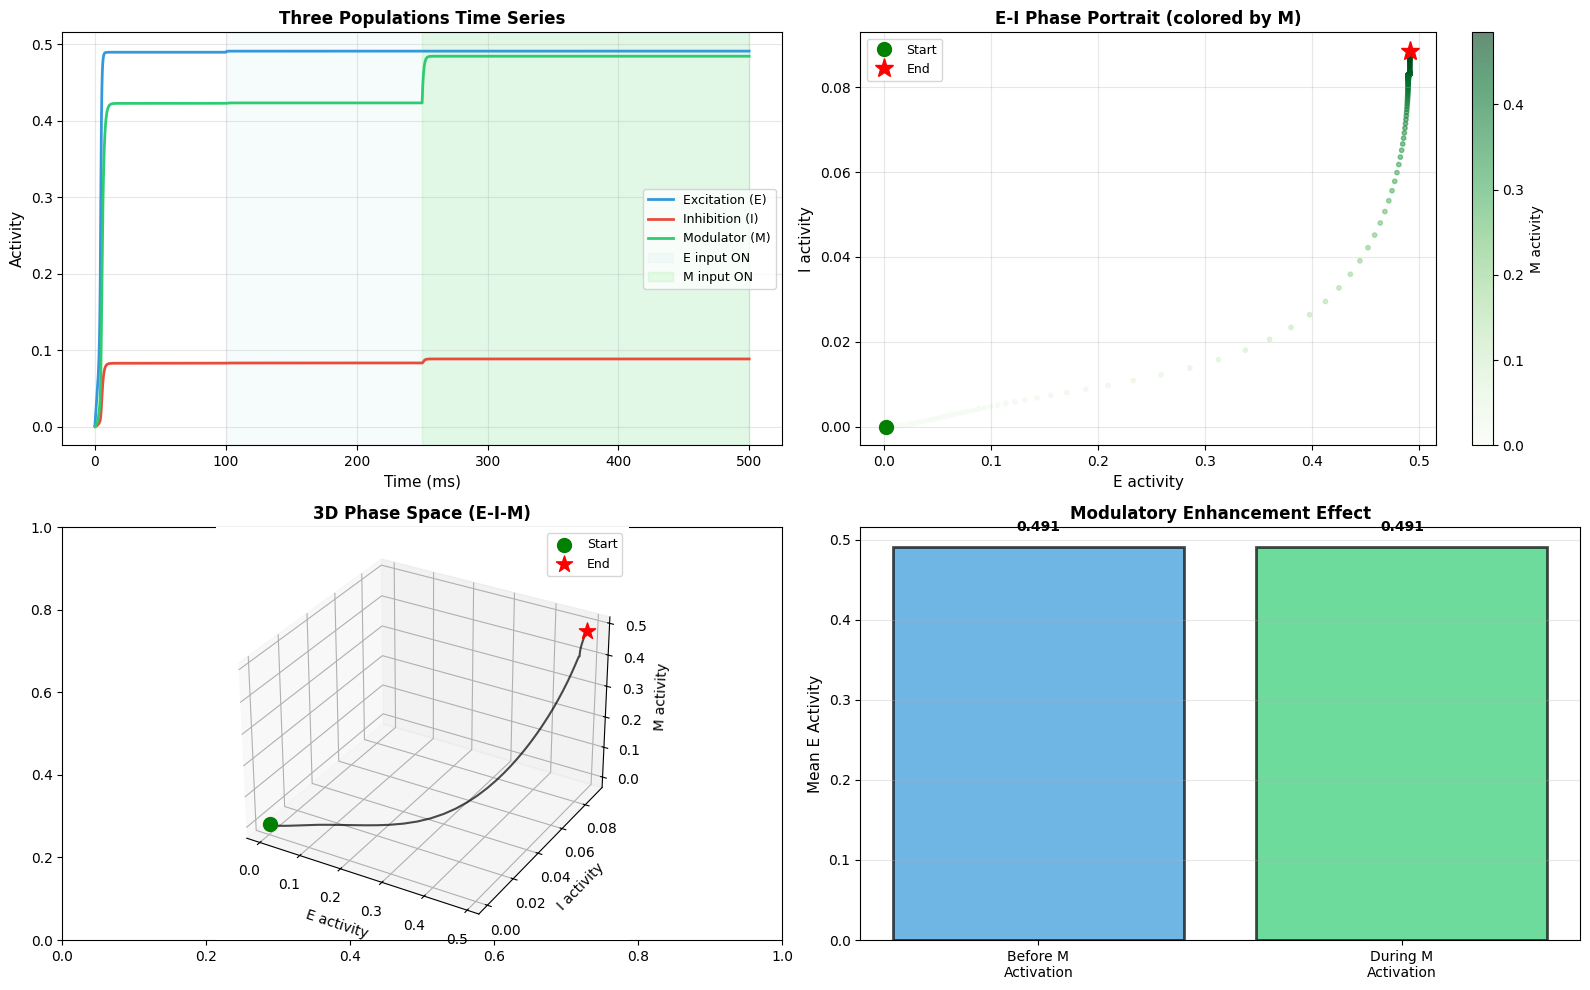

Observations:
  - Mean E before modulation: 0.491
  - Mean E during modulation: 0.491
  - Enhancement: 0.0%
  - Modulator enhances both E and I responses
  - Models attention, arousal, and neuromodulatory effects


In [8]:
# Create three-population model
model_3pop = brainmass.WilsonCowanThreePopulationStep(
    1,  # Single node
    tau_E=1.0 * u.ms,
    tau_I=1.0 * u.ms,
    tau_M=2.0 * u.ms,  # Modulator dynamics
    a_E=1.2,
    theta_E=2.8,
    a_I=1.0,
    theta_I=4.0,
    a_M=1.0,
    theta_M=3.0,
    # E-I connections
    wEE=12.,
    wEI=13.,
    wIE=4.,
    wII=11.,
    # Modulator → E/I connections
    wEM=4.,  # M enhances E
    wIM=2.,  # M enhances I
    # E/I → Modulator connections  
    wME=8.,  # E drives M
    wMI=6.,  # I inhibits M
    wMM=2.,  # M self-excitation
    r=1.
)
model_3pop.init_all_states()


# Run simulation with modulator activation
def step_run_3pop(i):
    t = i * brainstate.environ.get_dt()
    inp_E = u.math.where(t > 100 * u.ms, 2.0, 0.5)
    # Activate modulator from 250-500ms
    inp_M = u.math.where((t > 250 * u.ms) & (t < 500 * u.ms), 3.0, 0.0)
    model_3pop.update(rE_inp=inp_E, rI_inp=0.0, rM_inp=inp_M)
    return model_3pop.rE.value, model_3pop.rI.value, model_3pop.rM.value


rE_3pop, rI_3pop, rM_3pop = brainstate.transform.for_loop(step_run_3pop, indices)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Time series of all 3 populations
ax1 = axes[0, 0]
ax1.plot(time, rE_3pop[:, 0], color=E_COLOR, linewidth=2, label='Excitation (E)')
ax1.plot(time, rI_3pop[:, 0], color=I_COLOR, linewidth=2, label='Inhibition (I)')
ax1.plot(time, rM_3pop[:, 0], color=M_COLOR, linewidth=2, label='Modulator (M)')
ax1.axvspan(100, 500, color='lightblue', alpha=0.1, label='E input ON')
ax1.axvspan(250, 500, color='lightgreen', alpha=0.2, label='M input ON')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Activity', fontsize=11)
ax1.set_title('Three Populations Time Series', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# E-I phase portrait
ax2 = axes[0, 1]
# Color-code by M activity
scatter = ax2.scatter(rE_3pop[:, 0], rI_3pop[:, 0], c=rM_3pop[:, 0],
                      cmap='Greens', s=10, alpha=0.6)
ax2.plot(rE_3pop[0, 0], rI_3pop[0, 0], 'go', markersize=10, label='Start', zorder=5)
ax2.plot(rE_3pop[-1, 0], rI_3pop[-1, 0], 'r*', markersize=14, label='End', zorder=5)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('M activity', fontsize=10)
ax2.set_xlabel('E activity', fontsize=11)
ax2.set_ylabel('I activity', fontsize=11)
ax2.set_title('E-I Phase Portrait (colored by M)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3D phase space
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.plot(rE_3pop[:, 0], rI_3pop[:, 0], rM_3pop[:, 0], 'k-', linewidth=1.5, alpha=0.7)
ax3.scatter(rE_3pop[0, 0], rI_3pop[0, 0], rM_3pop[0, 0],
            color='green', s=100, marker='o', label='Start', zorder=10)
ax3.scatter(rE_3pop[-1, 0], rI_3pop[-1, 0], rM_3pop[-1, 0],
            color='red', s=150, marker='*', label='End', zorder=10)
ax3.set_xlabel('E activity', fontsize=10)
ax3.set_ylabel('I activity', fontsize=10)
ax3.set_zlabel('M activity', fontsize=10)
ax3.set_title('3D Phase Space (E-I-M)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)

# Modulator effect comparison
ax4 = axes[1, 1]
t_pre = (time >= 100 * u.ms) & (time < 250 * u.ms)  # Before M activation
t_post = (time >= 250 * u.ms) & (time < 400 * u.ms)  # During M activation
E_pre_mean = rE_3pop[t_pre, 0].mean()
E_post_mean = rE_3pop[t_post, 0].mean()
ax4.bar(['Before M\nActivation', 'During M\nActivation'],
        [E_pre_mean, E_post_mean],
        color=[E_COLOR, M_COLOR], alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Mean E Activity', fontsize=11)
ax4.set_title('Modulatory Enhancement Effect', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for i, v in enumerate([E_pre_mean, E_post_mean]):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  - Mean E before modulation: {E_pre_mean:.3f}")
print(f"  - Mean E during modulation: {E_post_mean:.3f}")
print(f"  - Enhancement: {((E_post_mean / E_pre_mean - 1) * 100):.1f}%")
print(f"  - Modulator enhances both E and I responses")
print(f"  - Models attention, arousal, and neuromodulatory effects")

## Part 3: Side-by-Side Comparison of All Variants

Now we'll compare all variants with identical input to see how they differ in their responses.

In [9]:
# Create all variants with compatible parameters
print("Creating all 11 Wilson-Cowan variants...")

# Common parameters for fair comparison
common_params = {
    'tau_E': 1.0 * u.ms,
    'tau_I': 1.0 * u.ms,
    'a_E': 1.2,
    'theta_E': 2.8,
    'a_I': 1.0,
    'theta_I': 4.0,
}

# Create all models
models = {}

# 1. Standard
models['Standard'] = brainmass.WilsonCowanStep(
    1, **common_params, wEE=12., wEI=13., wIE=4., wII=11., r=1.
)

# 2. No Saturation
models['NoSaturation'] = brainmass.WilsonCowanNoSaturationStep(
    1, **common_params, wEE=12., wEI=13., wIE=4., wII=11.
)

# 3. Symmetric (uses unified params)
models['Symmetric'] = brainmass.WilsonCowanSymmetricStep(
    1, tau=1.0 * u.ms, a=1.2, theta=2.8, wEE=12., wEI=13., wIE=4., wII=11., r=1.
)

# 4. Simplified
models['Simplified'] = brainmass.WilsonCowanSimplifiedStep(
    1, **common_params, w_exc=12., w_inh=11., r=1.
)

# 5. Linear
models['Linear'] = brainmass.WilsonCowanLinearStep(
    1, tau_E=1.0 * u.ms, tau_I=1.0 * u.ms, wEE=12., wEI=13., wIE=4., wII=11.
)

# 6. Divisive (Gain)
models['Divisive (Gain)'] = brainmass.WilsonCowanDivisiveStep(
    1, **common_params, wEE=6., wEI=6.5, wIE=2., wII=5.5, sigma_E=1., sigma_I=1., r=1.
)

# 7. Divisive (Input)
models['Divisive (Input)'] = brainmass.WilsonCowanDivisiveInputStep(
    1, **common_params, wEE=6., wEI=6.5, wIE=2., wII=5.5, sigma_E=1., sigma_I=1., r=1.
)

# 8. Delayed
models['Delayed'] = brainmass.WilsonCowanDelayedStep(
    1, **common_params, wEE=12., wEI=13., wIE=4., wII=11., r=1.,
    delay_EE=0.5 * u.ms, delay_IE=0.5 * u.ms, delay_EI=0.5 * u.ms, delay_II=0.5 * u.ms
)

# 9. Adaptive
models['Adaptive'] = brainmass.WilsonCowanAdaptiveStep(
    1, **common_params, wEE=12., wEI=13., wIE=4., wII=11., r=1.,
    tau_aE=50. * u.ms, tau_aI=50. * u.ms, b_E=0.3, b_I=0.2
)

# 10. Three-Population
models['ThreePopulation'] = brainmass.WilsonCowanThreePopulationStep(
    1, **common_params, a_M=1.0, theta_M=3.0, tau_M=2.0 * u.ms, r=1.,
    wEE=12., wEI=13., wIE=4., wII=11.,
    wEM=2., wIM=1., wME=4., wMI=3., wMM=1.
)

# Initialize all models
for name, model in models.items():
    model.init_all_states()

print(f"✅ Created {len(models)} variants\n")

# Simulate all variants with identical input
duration = 500 * u.ms
n_steps = int(duration / brainstate.environ.get_dt())
indices = np.arange(n_steps)
time = indices * brainstate.environ.get_dt()

results = {}

for name, model in models.items():
    print(f"Simulating {name}...", end=' ')


    def sim_func(i):
        t = i * brainstate.environ.get_dt()
        inp = u.math.where(t > 100 * u.ms, 2.0, 0.5)
        model.update(rE_inp=inp, rI_inp=0.0)
        return model.rE.value, model.rI.value


    rE, rI = brainstate.transform.for_loop(sim_func, indices)
    results[name] = (rE, rI)

    # Re-initialize for next simulation
    model.init_all_states()

    print("✓")

print("\n✅ All simulations complete!")

Creating all 11 Wilson-Cowan variants...
✅ Created 10 variants

Simulating Standard... ✓
Simulating NoSaturation... ✓
Simulating Symmetric... ✓
Simulating Simplified... ✓
Simulating Linear... ✓
Simulating Divisive (Gain)... ✓
Simulating Divisive (Input)... ✓
Simulating Delayed... ✓
Simulating Adaptive... ✓
Simulating ThreePopulation... ✓

✅ All simulations complete!


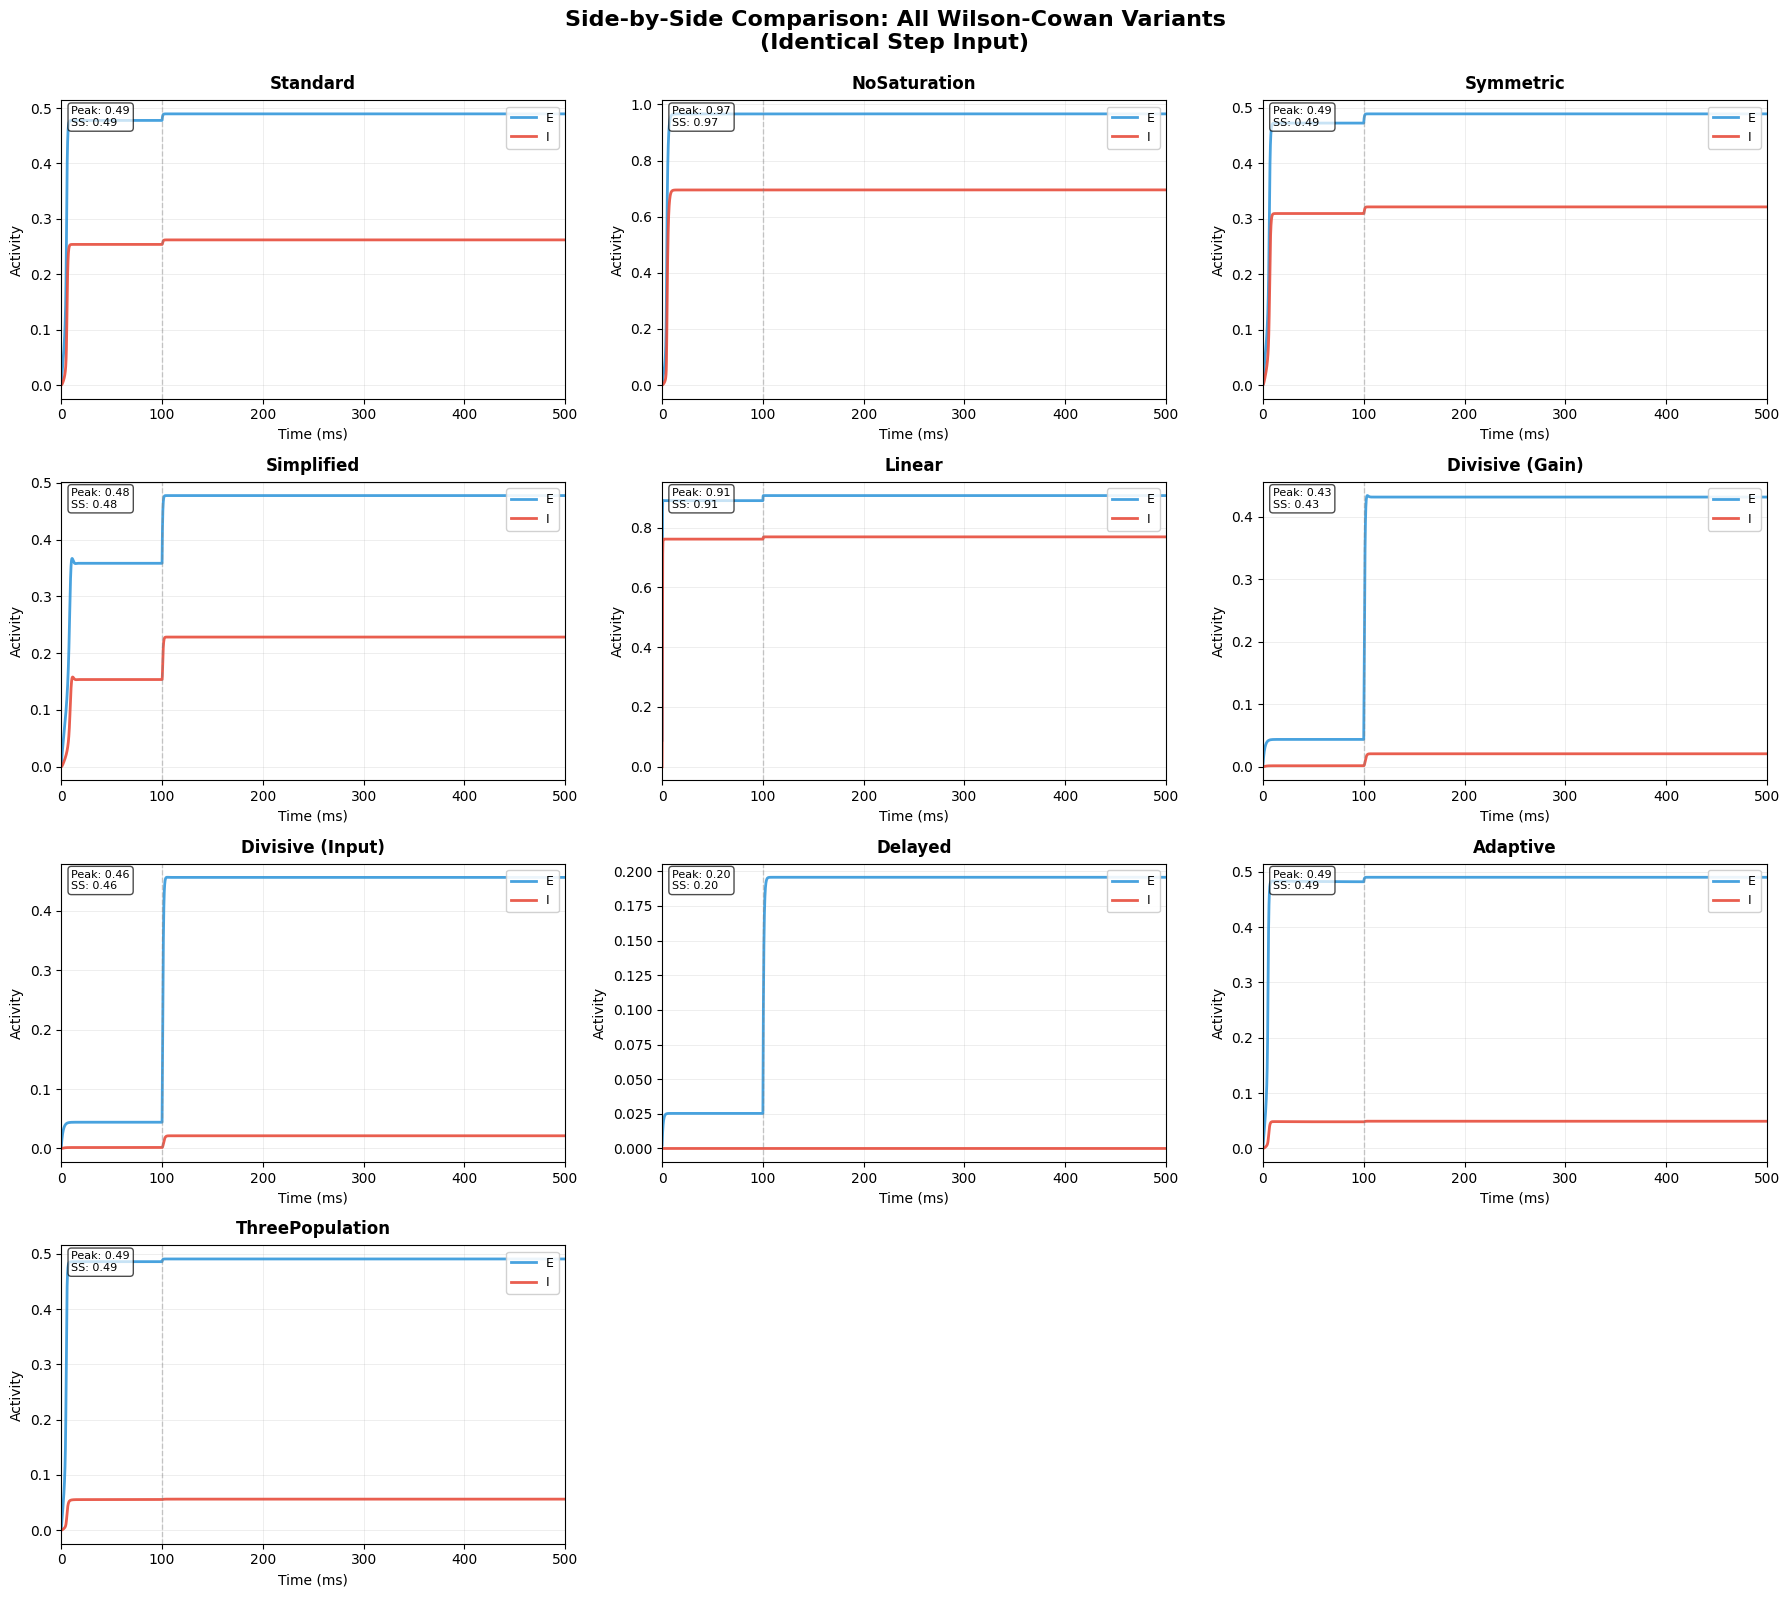


📊 Comparison Summary:
Variant              Peak E       Steady-State E  Rise Time
----------------------------------------------------------------------
Standard                  0.489           0.489        6.4 * msecond ms
NoSaturation              0.966           0.966        6.3 * msecond ms
Symmetric                 0.489           0.489        7.6 * msecond ms
Simplified                0.478           0.478      100.5 * msecond ms
Linear                    0.908           0.908        0.4 * msecond ms
Divisive (Gain)           0.434           0.432      101.7 * msecond ms
Divisive (Input)          0.456           0.456      101.9 * msecond ms
Delayed                   0.196           0.196      101.8 * msecond ms
Adaptive                  0.490           0.490        6.1 * msecond ms
ThreePopulation           0.491           0.491        5.9 * msecond ms


In [10]:
# Plot all variants in a grid
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, (name, (rE, rI)) in enumerate(results.items()):
    ax = axes[idx]

    # Plot E and I
    ax.plot(time, rE[:, 0], color=E_COLOR, linewidth=2, label='E', alpha=0.9)
    ax.plot(time, rI[:, 0], color=I_COLOR, linewidth=2, label='I', alpha=0.9)
    ax.axvline(100, color='gray', linestyle='--', alpha=0.4, linewidth=1)

    # Format
    ax.set_title(name, fontsize=12, fontweight='bold', pad=8)
    ax.set_xlabel('Time (ms)', fontsize=10)
    ax.set_ylabel('Activity', fontsize=10)
    ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.3, linewidth=0.5)
    ax.set_xlim([0, 500])

    # Add metrics as text
    peak_E = rE[:, 0].max()
    ss_E = rE[-100:, 0].mean()
    ax.text(
        0.02, 0.98,
        f'Peak: {peak_E:.2f}\nSS: {ss_E:.2f}',
        transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Hide extra subplots (we have 10 variants but 12 subplot positions)
for idx in range(len(results), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Side-by-Side Comparison: All Wilson-Cowan Variants\n(Identical Step Input)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n📊 Comparison Summary:")
print("=" * 70)
print(f"{'Variant':<20} {'Peak E':<12} {'Steady-State E':<15} {'Rise Time'}")
print("-" * 70)

for name, (rE, rI) in results.items():
    peak_E = rE[:, 0].max()
    ss_E = rE[-100:, 0].mean()

    # Find rise time (time to 90% of final value)
    target = ss_E * 0.9
    rise_idx = np.where(rE[:, 0] > target)[0]
    rise_time = time[rise_idx[0]] if len(rise_idx) > 0 else 0

    print(f"{name:<20} {peak_E:>10.3f}   {ss_E:>13.3f}   {rise_time:>8.1f} ms")

print("=" * 70)

## Part 4: Choosing the Right Variant - Decision Guide

### Decision Tree

```
What is your primary goal?

┌─ General exploratory modeling or teaching
│  └─> WilsonCowanStep (Standard) - Most versatile
│
├─ Need simpler/faster computation
│  └─> WilsonCowanNoSaturationStep - Simpler dynamics
│
├─ Reduce parameter space for fitting
│  └─> WilsonCowanSymmetricStep - Fewer parameters
│
├─ Pedagogical demonstrations
│  └─> WilsonCowanSimplifiedStep - Minimal complexity
│
├─ Optimization/gradient-based learning
│  └─> WilsonCowanLinearStep - ReLU activation
│
├─ Model visual cortex normalization
│  ├─> Gain control: WilsonCowanDivisiveStep
│  └─> Input normalization: WilsonCowanDivisiveInputStep
│
├─ Include realistic axonal delays
│  └─> WilsonCowanDelayedStep - Connection delays
│
├─ Model neural fatigue/habituation
│  └─> WilsonCowanAdaptiveStep - Adaptation currents
│
└─ Model attention/arousal/neuromodulation
   └─> WilsonCowanThreePopulationStep - Modulatory neurons
```

### Feature Comparison Table

| Feature | Standard | NoSat | Sym | Simp | Linear | DivG | DivI | Delay | Adapt | 3Pop |
|---------|:--------:|:-----:|:---:|:----:|:------:|:----:|:----:|:-----:|:-----:|:----:|
| **States** | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 4 | 3 |
| **Parameters** | 11 | 10 | 8 | 9 | 7 | 13 | 13 | 15 | 15 | 18 |
| **Nonlinear** | ✓ | ✓ | ✓ | ✓ | ✗ | ✓ | ✓ | ✓ | ✓ | ✓ |
| **Delays** | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✓ | ✗ | ✗ |
| **Adaptation** | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✓ | ✗ |
| **Modulation** | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✓ |
| **Normalization** | ✗ | ✗ | ✗ | ✗ | ✗ | ✓ | ✓ | ✗ | ✗ | ✗ |
| **Complexity** | Med | Low | Low | Low | Low | Med | Med | Med | High | High |
| **Stability** | Good | Good | Good | Good | Good | Med | Med | Med | Good | Good |

### Use Case Recommendations

**Cognitive Neuroscience:**
- Working memory: **Standard** or **Adaptive** (for fatigue effects)
- Attention: **ThreePopulation** (modulator = attention signal)
- Decision making: **Standard** or **Symmetric**

**Sensory Processing:**
- Visual cortex V1: **Divisive** variants (contrast normalization)
- Auditory cortex: **Standard** or **NoSaturation**
- Somatosensory: **Standard**

**Network Modeling:**
- Large-scale brain networks: **Delayed** (realistic transmission delays)
- Small local circuits: **Standard** or **Simplified**
- Whole-brain models: **Standard** or **Linear** (for speed)

**Machine Learning:**
- Training recurrent networks: **Linear** (gradient-friendly)
- Reservoir computing: **Standard** or **NoSaturation**
- Neuromorphic computing: **Adaptive** or **ThreePopulation**

**Clinical Applications:**
- Epilepsy modeling: **Standard** (captures seizure dynamics)
- Fatigue/habituation: **Adaptive**
- Arousal disorders: **ThreePopulation**


## References

**Original Wilson-Cowan Model:**
- Wilson, H. R., & Cowan, J. D. (1972). Excitatory and inhibitory interactions in localized populations of model neurons. *Biophysical Journal*, 12(1), 1-24.

**Divisive Normalization:**
- Carandini, M., & Heeger, D. J. (2012). Normalization as a canonical neural computation. *Nature Reviews Neuroscience*, 13(1), 51-62.
- Heeger, D. J. (1992). Normalization of cell responses in cat striate cortex. *Visual Neuroscience*, 9(2), 181-197.

**Spike-Frequency Adaptation:**
- Benda, J., & Herz, A. V. (2003). A universal model for spike-frequency adaptation. *Neural Computation*, 15(11), 2523-2564.
- Wang, X. J. (1998). Calcium coding and adaptive temporal computation in cortical pyramidal neurons. *Journal of Neurophysiology*, 79(3), 1549-1566.

**Delay Models:**
- Robinson, P. A., Rennie, C. J., & Wright, J. J. (1997). Propagation and stability of waves of electrical activity in the cerebral cortex. *Physical Review E*, 56(1), 826.
- Jirsa, V. K., & Haken, H. (1996). Field theory of electromagnetic brain activity. *Physical Review Letters*, 77(5), 960.

**Neuromodulation:**
- Deco, G., Ponce-Alvarez, A., Mantini, D., Romani, G. L., Hagmann, P., & Corbetta, M. (2013). Resting-state functional connectivity emerges from structurally and dynamically shaped slow linear fluctuations. *Journal of Neuroscience*, 33(27), 11239-11252.
- Shine, J. M. (2019). Neuromodulatory influences on integration and segregation in the brain. *Trends in Cognitive Sciences*, 23(7), 572-583.
